In [1]:
#Assignment 10
#Vehicle tracking based on GPS and odometry data fusion
#Team 12
#Yaroslav Savotin, Elizaveta Pestova, Selamawit Asfaw
#Skoltech, 2023

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#----------------------------------------------------------------------------------------------------
#--------------------Part I. Assimilation of GPS data only (absolute positioning)--------------------
#----------------------------------------------------------------------------------------------------


#------------№1------------
df = pd.read_csv("theta.csv") 
Teta = df['angle'].values[:]
#Teta

In [3]:
# Initial parameters
N = 500
step = np.arange(N)
T = 0.05

# Initial position and velocity
#[x0,Vx0,y0,Vy0]
x0 = np.array([[0], [np.sqrt(50)], [0], [np.sqrt(50)]])

#Variance of noise
sigma_a = 1**2
#Variances of measurement noises
sigmaX = 3**2
sigmaY = 3**2

# Transition Matrix
Fi = np.array([[1, T, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, T],
               [0, 0, 0, 1]])

# Input matrix
G = np.array([[(T**2)/2, 0],
              [T, 0],
              [0 ,(T**2)/2],
              [0, T]])

#Observation matrix
H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

#Covariance matrix of state noise
Q = np.dot(G,G.T)*sigma_a

In [4]:
#Function for genereting cartesian coordinates x,y and components of velocity
def generate_Xt(x0, Fi, G, sigma_a, N):
    ax = np.random.normal(0, np.sqrt(sigma_a), size = (1, 1, N))
    ay = np.random.normal(0, np.sqrt(sigma_a), size =(1, 1, N))
    
    Fi1 = np.zeros((4, 4, N))
    for i in range(N):
        Fi1[:, :, i] = np.array([[1, T * np.cos(Teta[i]), 0, 0],
                        [0, np.cos(Teta[i]), 0, 0],
                        [0, 0, 1, T * np.sin(Teta[i])],
                        [0, 0, 0, np.sin(Teta[i])]])
    
    A = np.zeros((2, 1, N))
    for i in range(N):
        A[0,0,i] = ax[0][0][i]
        A[1,0,i] = ay[0][0][i]
    
    Xt = np.zeros((4, 1, N))
    Xt[:, :, 0] = x0
    for i in range(1, N):
        Xt[:, :, i] = np.dot(Fi1[:, :, i-1],Xt[:, :, i-1]) + np.dot(G,A[:, :, i-1])
    return Xt


def generate_Z(sigmaX,sigmaY, Xt, H, N):
    nuX = np.random.normal(0, np.sqrt(sigmaX), size=(1, 1, N))
    nuY = np.random.normal(0, np.sqrt(sigmaY), size=(1, 1, N))
    
    Nu = np.zeros((2, 1, N))
    for i in range(N):
        Nu[0,0,i] = nuX[0,0,i]
        Nu[1,0,i] = nuY[0,0,i]
    
    Z = np.zeros((2, 1, N))

    for i in range(N):
        Z[:, :, i] = np.dot(H, Xt[:, :, i]) + Nu[:, :, i]
    return Z


#Kalman filter
def linear_kalmanFilter(Fi, H, R, X0, P0, Zm, Q, N):
    Xp = np.zeros((4, 1, N))
    Pf = np.zeros((4, 4, N))
    Pp = np.zeros((4, 4, N))
    Xf = np.zeros((4, 1, N))
    K = np.zeros((4, 2, N))
    Ps = np.zeros((4, 1, N))
    Pf[:, :, 0] = P0
    Xf[:, :, 0] = X0
    
    for i in range(1, N):
        Xp[:, :, i] = np.dot(Fi, Xf[:, :, i-1])
        Pp[:, :, i] = np.dot(np.dot(Fi, Pf[:, :, i-1]), np.transpose(Fi)) + Q
        K[:, :, i] = np.dot(np.dot(Pp[:, :, i], np.transpose(H)), np.linalg.inv(np.dot(np.dot(H, Pp[:, :, i]), np.transpose(H)) + R))
        Xf[:, :, i] = Xp[:, :, i] + np.dot(K[:, :, i], (Zm[:, :, i] - np.dot(H, Xp[:, :, i])))
        Pf[:, :, i] = np.dot((np.eye(4) - np.dot(K[:, :, i], H)), Pp[:, :, i])
        Ps[:, :, i] = np.sqrt(np.abs(np.diag(Pf[:, :, i])[0]))
    
    return Xf, Xp, K, Ps


#Function that calculate MSE over M run of the Kalman filter
def calculate_MSE_1(N, Xt,Xf):
    Error_run = np.zeros((4, 1, N))

    for j in range(N):
        Error_run[:, :, j] = np.sqrt((Xt[:, :, j] - Xf[:, :, j])**2)
        
    return Error_run


def calculate_MSE_500(N, M, x0, sigma_a, sigmaX, sigmaY, Fi, G, H, Q, R, X0, P0):
    Error_run = np.zeros((4, M, N))
    final_Error = np.zeros((4, 1, N-3))
    Error_run1 = np.zeros((4, M, N))
    final_Error1 = np.zeros((4, 1, N-3))
    
    True_error = np.zeros((4, M, N))
    final_True_error = np.zeros((4, 1, N-3))

    for i in range(M):
        Xt = generate_Xt(x0, Fi, G, sigma_a, N)
        Z = generate_Z(sigmaX,sigmaY, Xt, H, N)
        Xf, Xp, K, Ps = linear_kalmanFilter(Fi, H, R, X0, P0, Z, Q, N)
        Zm = np.zeros((4, 1, N))
        for i in range(N):
            Zm[0,0,i] = Z[0,0,i]
            Zm[2,0,i] = Z[1,0,i]

        for j in range(N):
            Error_run[:, i, j] = ((Xt[:, :, j] - Xf[:, :, j])**2).T[0]
            Error_run1[:, i, j] = ((Xt[:, :, j] - Xp[:, :, j])**2).T[0]
            
            True_error[:, i, j] = ((Xt[:, :, j] - Zm[:, :, j])**2).T[0]

    for i in range(N-3):
        for k in range(M):
            final_Error[:, :, i] += Error_run[:, k, i+3].T[0]
            final_Error1[:, :, i] += Error_run1[:, k, i+3].T[0]
            
            final_True_error[:, :, i] += True_error[:, k, i+3].T[0]
            
        final_Error[:, :, i] = np.sqrt(final_Error[:, :, i] / (M - 1))
        final_Error1[:, :, i] = np.sqrt(final_Error1[:, :, i] / (M - 1))
        
        final_True_error[:, :, i] = np.sqrt(final_True_error[:, :, i] / (M - 1))

    return final_Error, final_Error1, final_True_error, Ps

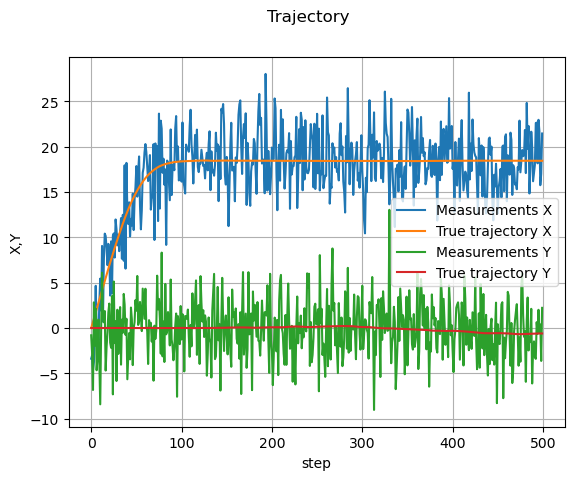

In [5]:
#------------№2------------
# Generate true trajectories
Xt = generate_Xt(x0, Fi, G, sigma_a, N)

#------------№3------------
# Generate measurement trajectories
Z = generate_Z(sigmaX,sigmaY, Xt, H, N)

plt.plot(step,Z[0][0],label = 'Measurements X')
plt.plot(step,Xt[0][0],label = 'True trajectory X')
plt.plot(step,Z[1][0],label = 'Measurements Y')
plt.plot(step,Xt[2][0],label = 'True trajectory Y')
plt.xlabel('step')
plt.ylabel('X,Y')
plt.suptitle('Trajectory')
plt.legend()
plt.grid(True)

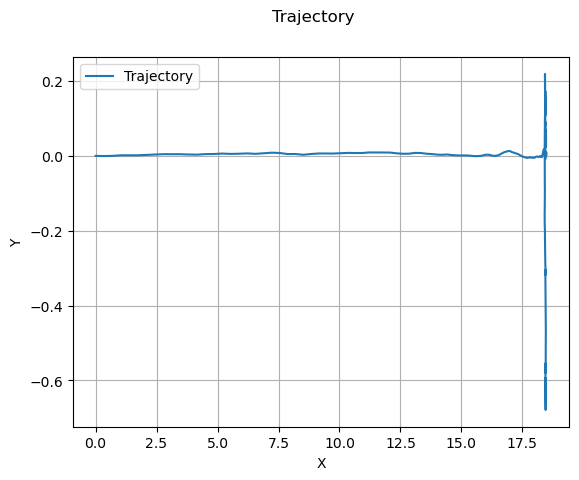

In [6]:
plt.plot(Xt[0][0],Xt[2][0],label = 'Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.suptitle('Trajectory')
plt.legend()
plt.grid(True)

In [7]:
#------------№4------------

#Initial filtered estimate of state vector
X0 = np.array([[Z[0, 0, 1] ],
              [(Z[0, 0, 1] - Z[0, 0, 0]) / T],
              [Z[0, 0, 1]],
              [(Z[0, 0, 1] - Z[0, 0, 0])/ T]])

#Initial filtration error covariance matrix
P0 = np.array([[10**4, 0, 0, 0],
               [0, 10**4, 0, 0],
               [0, 0, 10**4, 0],
               [0, 0, 0, 10**4]])

#Measurement noise covariance matrix 
R = np.array([[sigmaX,0],
              [0,sigmaY]])


In [8]:
Xf, Xp, K, Ps = linear_kalmanFilter(Fi, H, R, X0, P0, Z, Q, N)

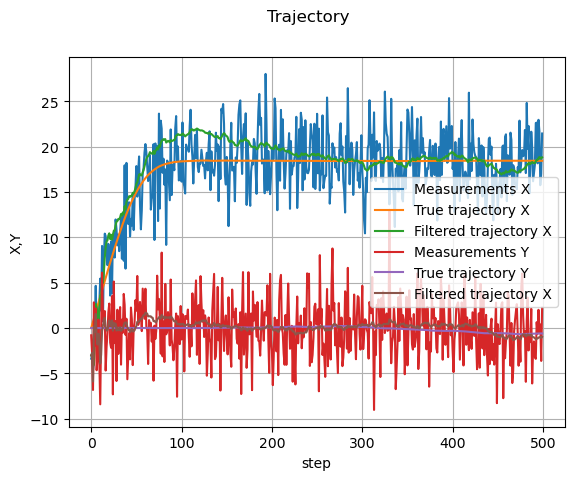

In [9]:
plt.plot(step,Z[0][0],label = 'Measurements X')
plt.plot(step,Xt[0][0],label = 'True trajectory X')
plt.plot(step,Xf[0][0],label = 'Filtered trajectory X')
plt.plot(step,Z[1][0],label = 'Measurements Y')
plt.plot(step,Xt[2][0],label = 'True trajectory Y')
plt.plot(step,Xf[2][0],label = 'Filtered trajectory X')
plt.xlabel('step')
plt.ylabel('X,Y')
plt.suptitle('Trajectory')
plt.legend()
plt.grid(True)

In [10]:
#------------№5------------
M = 500
step1 = np.arange(N-3)
MSE_500F,MSE_500P, final_True_error, Ps = calculate_MSE_500(N, M, x0, sigma_a, sigmaX, sigmaY, Fi, G, H, Q, R, X0, P0)

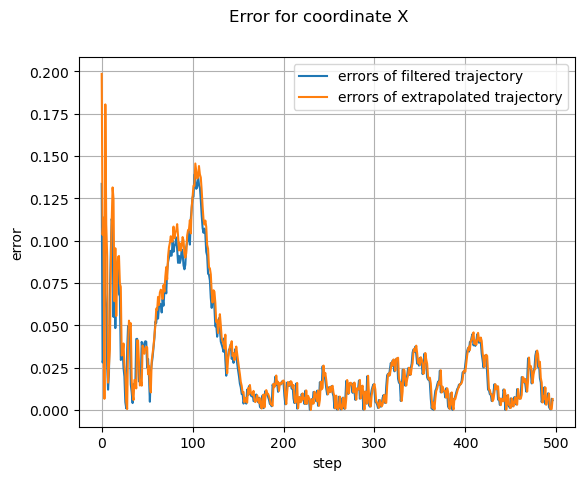

In [11]:
y1 = MSE_500F[0, 0, :]
y2 = MSE_500P[0, 0, :]
x = step1
plt.plot(x,y1,label = 'errors of filtered trajectory')
plt.plot(x,y2,label = 'errors of extrapolated trajectory')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error for coordinate X')
plt.legend()
plt.grid(True)

In [63]:
#----------------------------------------------------------------------------------------------------------------
#----------Part II. Assimilation of both GPS data (absolute positioning) and wheel odometry data-----------------
#-----------------------------------------(relative positioning)-------------------------------------------------


In [64]:
def generate_V(Xt,N):
    V = np.zeros((1, 1, N))
    Vm = np.zeros((1, 1, N))
    sigmaV = 0.5**2
    
    nuV = np.random.normal(0, np.sqrt(sigmaV), size=(1, 1, N))
    
    for i in range(N):
        V[:, :, i] = np.sqrt(Xt[1, :, i]**2 + Xt[3, :, i]**2)
        Vm[:, :, i] = V[:, :, i] + nuV[:, :, i]
    return Vm

def generate_TetaM(Teta,N):
    TetaM = np.zeros((1, 1, N))
    sigmaT = 0.02**2
    
    nuT = np.random.normal(0, np.sqrt(sigmaT), size=(1, 1, N))
    
    for i in range(N):
        TetaM[:, :, i] = Teta[i] + nuT[:, :, i]
    return TetaM

def generate_Zm(Z,Vm,TetaM):    
    Zm = np.zeros((4, 1, N))

    for i in range(N):
        Zm[:2, :, i] = Z[:, :, i]
        Zm[2, :, i] = Vm[:, :, i]
        Zm[3, :, i] = TetaM[:, :, i]
    return Zm

def generate_h(X, h, i):    
    h[0, :, i] = X[0, :, i]
    h[1, :, i] = X[2, :, i]
    h[2, :, i] = np.sqrt(X[1, :, i]**2 + X[3, :, i]**2)[0]
    h[3, :, i] = np.arctan(X[1, :, i]/X[3, :, i])[0]
    return h

def generate_dh(X,h, dh, i):    
    dh[:, :, i] = np.array([[1, 0, 0, 0],
                            [0, 0, 1, 0],
                            [0, (X[1, :, i]/h[2, :, i])[0], 0, (X[3, :, i]/h[2, :, i])[0]],
                            [0, (-X[3, :, i]/h[2, :, i]**2)[0], 0, (X[1, :, i]/h[2, :, i]**2)[0]]])
    return dh

In [65]:
#------------№3,4------------
Vm = generate_V(Xt,N)
TetaM = generate_TetaM(Teta,N)

In [85]:
#------------№5------------
Zm = generate_Zm(Z,Vm,TetaM)

#Initial filtered estimate of state vector
X0 = np.array([[Zm[0, 0, 1] ],
              [(Zm[0, 0, 1] - Zm[0, 0, 0]) / T],
              [Zm[0, 0, 1]],
              [(Zm[0, 0, 1] - Zm[0, 0, 0])/ T]])

#Initial filtration error covariance matrix
P0 = np.array([[10**4, 0, 0, 0],
               [0, 10**4, 0, 0],
               [0, 0, 10**4, 0],
               [0, 0, 0, 10**4]])


R = np.array([[sigmaX, 0, 0, 0],
               [0, sigmaY, 0, 0],
               [0, 0, 0.5**2, 0],
               [0, 0, 0, 0.02**2]])

In [90]:
def Extended_kalmanFilter(Fi, Q, R, G, Zm, N):
    
    Xf = np.zeros((4, 1, N)) #Filtration of state vector
    Pf = np.zeros((4, 4, N)) #Filtration error covariance matrix
    Xp = np.zeros((4, 1, N)) #Prediction of state vector
    Pp = np.zeros((4, 4, N)) #Prediction error covariance matrix
    
    
    K = np.zeros((4, 4, N)) #Filter gain
    dh = np.zeros((4, 4, N)) #Derivative
    h = np.zeros((4, 1, N)) #Nonlinear function
    
    Pf[:, :, 0] = P0
    Xf[:, :, 0] = X0
    

    for i in range(N-1):
        #Prediction (extrapolation)
        Xp[:, :, i+1] = np.dot(Fi, Xf[:, :, i])
        
        Pp[:, :, i+1] = np.dot(np.dot(Fi, Pf[:, :, i]), np.transpose(Fi)) + Q
        
        h = generate_h(Xp, h, i+1)
        dh = generate_dh(Xp,h, dh, i+1)
        

        #Filtration
            #Filter gain
        K[:, :, i+1] = np.dot(np.dot(Pp[:, :, i+1], np.transpose(dh[:, :, i+1])), np.linalg.inv(np.dot(np.dot(dh[:, :, i+1], Pp[:, :, i+1]), np.transpose(dh[:, :, i+1])) + R))
            #Improved estimate by incorporating a new measurement
        Xf[:, :, i+1] = Xp[:, :, i+1] + np.dot(K[:, :, i+1], (Zm[:, :, i+1] - h[:, :, i+1]))

            #Filtration error covariance matri
        Pf[:, :, i+1] = np.dot((np.eye(4) - np.dot(K[:, :, i+1], dh[:, :, i+1])), Pp[:, :, i+1])
    
    return Xf, Xp, K

In [91]:
Xf2, Xp2, K = Extended_kalmanFilter(Fi, Q, R, G, Zm, N)

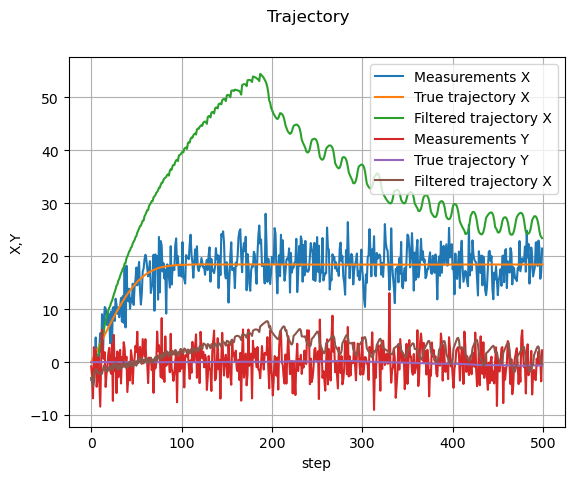

In [104]:
plt.plot(step,Zm[0][0],label = 'Measurements X')
plt.plot(step,Xt[0][0],label = 'True trajectory X')
plt.plot(step,Xf2[0][0],label = 'Filtered trajectory X')
plt.plot(step,Zm[1][0],label = 'Measurements Y')
plt.plot(step,Xt[2][0],label = 'True trajectory Y')
plt.plot(step,Xf2[2][0],label = 'Filtered trajectory X')
plt.xlabel('step')
plt.ylabel('X,Y')
plt.suptitle('Trajectory')
plt.legend()
plt.grid(True)

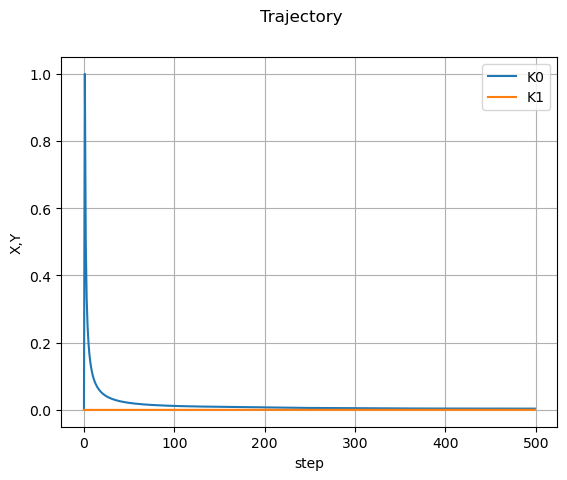

In [105]:
#plt.plot(step,K[0][0],label = 'K0')
#plt.plot(step,K[0][1],label = 'K1')
#plt.plot(step,K[0][2],label = 'K2')
#plt.plot(step,K[0][3],label = 'K3')
#plt.xlabel('step')
#plt.ylabel('X,Y')
#plt.suptitle('Trajectory')
#plt.legend()
#plt.grid(True)

In [121]:
def calculate_MSE_500_Extended(N, M, x0, sigma_a, sigmaX, sigmaY, Fi, G, H, Q, R, X0, P0):
    Error_run = np.zeros((4, M, N))
    final_Error = np.zeros((4, 1, N-3))
    Error_run1 = np.zeros((4, M, N))
    final_Error1 = np.zeros((4, 1, N-3))
    
    True_error = np.zeros((4, M, N))
    final_True_error = np.zeros((4, 1, N-3))

    for i in range(M):
        Xt = generate_Xt(x0, Fi, G, sigma_a, N)
        Z = generate_Z(sigmaX,sigmaY, Xt, H, N)
        Vm = generate_V(Xt,N)
        TetaM = generate_TetaM(Teta,N)
        Zm = generate_Zm(Z,Vm,TetaM)
        
        Xf, Xp, K = Extended_kalmanFilter(Fi, Q, R, G, Zm, N)


        for j in range(N):
            Error_run[:, i, j] = ((Xt[:, :, j] - Xf[:, :, j])**2).T[0]
            Error_run1[:, i, j] = ((Xt[:, :, j] - Xp[:, :, j])**2).T[0]
            
            True_error[:, i, j] = ((Xt[:, :, j] - Zm[:, :, j])**2).T[0]

    for i in range(N-3):
        for k in range(M):
            final_Error[:, :, i] += Error_run[:, k, i+3].T[0]
            final_Error1[:, :, i] += Error_run1[:, k, i+3].T[0]
            
            final_True_error[:, :, i] += True_error[:, k, i+3].T[0]
            
        final_Error[:, :, i] = np.sqrt(final_Error[:, :, i] / (M - 1))
        final_Error1[:, :, i] = np.sqrt(final_Error1[:, :, i] / (M - 1))
        
        final_True_error[:, :, i] = np.sqrt(final_True_error[:, :, i] / (M - 1))

    return final_Error, final_Error1, final_True_error, Ps, Xf

In [122]:
#------------№6------------
final_Error2, final_Error12, final_True_error2, Ps2, Xf500 = calculate_MSE_500_Extended(N, M, x0, sigma_a, sigmaX, sigmaY, Fi, G, H, Q, R, X0, P0)

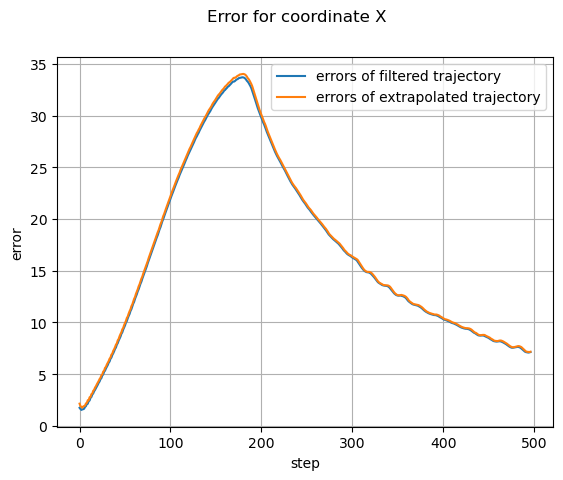

In [123]:
y1 = final_Error2[0, 0, :]
y2 = final_Error12[0, 0, :]
x = step1
plt.plot(x,y1,label = 'errors of filtered trajectory')
plt.plot(x,y2,label = 'errors of extrapolated trajectory')
plt.xlabel('step')
plt.ylabel('error')
plt.suptitle('Error for coordinate X')
plt.legend()
plt.grid(True)